In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image

# generate dataset

In [2]:
x = np.linspace(-1,1,10000000)
order = 100
params = np.random.normal(size=order)
# params

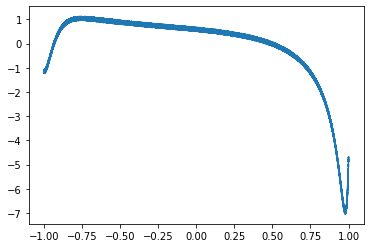

In [3]:
y = 0
for i in range(order):
    y = y + params[i]*x**i
y = y + np.random.normal(scale=0.02,size=len(x))
plt.plot(x,y)

# dataloader

In [4]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return np.array([x]), np.array([y])

# build model

In [5]:
class Net(torch.nn.Module):
    def __init__(self, order=3):
        super(Net, self).__init__()
        self.order = order
        self.params = torch.nn.Parameter(torch.randn(self.order, dtype=torch.float32), requires_grad=True)
        
        
    def forward(self, x):
        out = 0
        for i in range(self.order):
            out = out + self.params[i]*x**i
        return out

# Train

In [6]:
model = Net(100)
device = torch.device("cuda:0")
model = torch.nn.DataParallel(model, device_ids=[0,1])
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

In [7]:
test_dataset = dataset(x,y)
train_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=1000000, 
                                             shuffle=True,
                                             num_workers=12)

In [8]:
loss_history = []
model.train()
for epoch in range(30):
    for idx, (inpt, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        pred = model(inpt.to(device))
        loss = torch.nn.MSELoss()(pred, target.to(device))
        loss.backward()
        optimizer.step()
        print(epoch, idx, loss.item())
        loss_history.append(loss.item())

0 0 9.98367840705338
0 1 7.1358134882823165
0 2 5.048083927018086
0 3 3.600680132097444
0 4 2.7320611336410394
0 5 2.3439750021728885
0 6 2.265400784961951
0 7 2.27074447804205
0 8 2.232692015008649
0 9 2.1146042022659457
1 0 1.8863466637653206
1 1 1.6139896255062423
1 2 1.3367491731084233
1 3 1.104508931360191
1 4 0.929183173321925
1 5 0.8289711704699801
1 6 0.7911308423268377
1 7 0.7924816302015747
1 8 0.7943702467035708
1 9 0.7632087460691803
2 0 0.6949591509440038
2 1 0.5877399385036336
2 2 0.46329651288783547
2 3 0.332195989808137
2 4 0.22104765718917815
2 5 0.13592768644937475
2 6 0.08829181021407027
2 7 0.07582868847002174
2 8 0.09047901484641781
2 9 0.11718109259346164
3 0 0.14182276253041023
3 1 0.1548496051446532
3 2 0.1533724342719768
3 3 0.13954265663047485
3 4 0.12005441594386304
3 5 0.10130672001607348
3 6 0.08705139163113437
3 7 0.08159069622917182
3 8 0.08147482332079647
3 9 0.0858842575295736
4 0 0.08976877922848737
4 1 0.0882392444522923
4 2 0.08264297505502578
4 3 0.

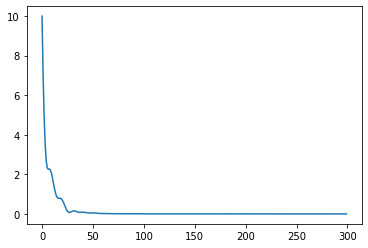

In [9]:
plt.plot(loss_history)

In [11]:
model.module.params, params

(Parameter containing:
 tensor([ 0.5486, -0.7611,  0.0658, -0.3988, -0.9718, -0.9992, -1.9194, -0.2260,
          0.4689,  0.2998, -0.3657, -1.8426, -0.9914, -0.6322, -0.0789,  0.7569,
         -1.8835, -2.1763,  0.5486, -0.1219, -0.2241,  0.6970, -0.2553,  2.0064,
         -0.4031,  0.2196,  1.4183,  0.2267, -0.3030,  1.0674, -0.3398,  0.7862,
         -1.1072, -0.5493, -1.0664,  0.2937,  0.5418, -0.2687, -0.5949,  0.6683,
          0.7625, -1.1070,  0.5881,  0.4644, -1.7230, -0.7600, -0.8818, -0.8845,
          0.1066,  0.3814,  1.6992,  0.2358,  0.7625, -0.3051, -0.7270, -1.4047,
         -0.4417, -0.4397,  0.2185, -0.9340,  1.8901,  0.7824, -0.2439, -0.5651,
          0.1492,  0.5470,  0.5856, -0.8085, -0.9717, -0.0988, -1.9906, -0.7431,
          0.2560,  0.9628,  1.0010,  0.0544, -0.3614, -0.0353,  0.0590, -0.7499,
          0.9970,  0.5474, -0.8685,  1.0336,  1.8581, -0.7094, -0.1160, -0.9637,
          0.9883,  0.7509,  0.5961,  0.9860, -0.2828,  1.2948, -0.8250,  0.2557,
     

In [12]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, 
                                              batch_size=10000000, 
                                             shuffle=False,
                                             num_workers=12)

In [13]:
inpt, target = next(iter(test_dataloader))
model.eval()
with torch.no_grad():
    pred = model(inpt.to(device))
pred.shape

torch.Size([10000000, 1])

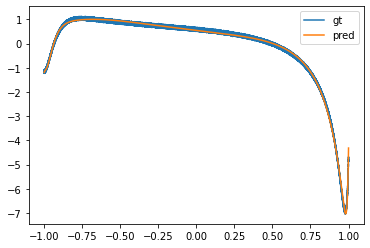

In [14]:
plt.plot(x, y, label="gt")
plt.plot(x, pred.data.cpu().numpy().reshape(-1), label="pred")
plt.legend()

In [70]:
params

tensor([ 0.2904, -1.3879,  0.1926], requires_grad=True)

In [52]:
test_net = Net()

In [53]:
inpt, target = next(iter(test_dataloader))

In [54]:
pred = test_net(inpt)
pred.shape

torch.Size([100, 1])

In [55]:
pred

tensor([[-1.7546],
        [-1.1943],
        [-1.5217],
        [-1.7836],
        [-1.5862],
        [-1.7387],
        [-1.6849],
        [-1.8323],
        [-1.3163],
        [-1.5543],
        [-1.1596],
        [-1.5926],
        [-1.8259],
        [-1.3023],
        [-1.0948],
        [-1.6713],
        [-1.8285],
        [-1.7407],
        [-1.1631],
        [-1.7629],
        [-1.8152],
        [-1.8235],
        [-1.3224],
        [-0.9644],
        [-1.5588],
        [-1.8352],
        [-1.2834],
        [-1.4295],
        [-1.7806],
        [-1.5577],
        [-0.9703],
        [-1.5108],
        [-1.5688],
        [-1.7685],
        [-1.4457],
        [-1.3496],
        [-1.5193],
        [-1.3541],
        [-1.6499],
        [-1.5335],
        [-1.8329],
        [-1.3600],
        [-1.6535],
        [-1.0328],
        [-1.8080],
        [-1.3331],
        [-1.3116],
        [-1.8293],
        [-1.5978],
        [-1.3673],
        [-1.7206],
        [-1.5655],
        [-1.